In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


I'll test a convolutional autoencoder to encode the coherence matrices between pairs of nodes. And then I'll apply a dimentionality reduction technique (TSNE, PCA) on the code generate by the autoencoder to try to separate different coherence patternes generated by each link.

In [2]:
import tensorflow as tf
import keras
from   keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
#######################################################################
# LOADING COHERENCE DATA
#######################################################################
data = np.load('/content/data.npy', allow_pickle=True)
data = data.reshape([5000, 127, 28, 1])
IMG_SHAPE = data.shape[1:]
X_train, X_test = train_test_split(data, test_size=0.1, random_state=42)

In [4]:
#######################################################################
# DEFINING CONVOLUTIONAL AUTOENCODER 
#######################################################################
def build_deep_autoencoder(img_shape, code_size):

    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    fsize = [32, 64, 128, 256]    
    fsize2= [128, 64, 32, 1]
 
    #################################################################################
    # ENCODER
    #################################################################################
    encoder = keras.models.Sequential()
    encoder.add(keras.layers.InputLayer(img_shape))
    
    for f in fsize:
        encoder.add(keras.layers.Conv2D(f, (3,3), padding="same", activation = 'elu') )
        encoder.add(keras.layers.MaxPooling2D(pool_size=(2,2), padding="same") )
    
    encoder.add(keras.layers.Flatten())  
    encoder.add(keras.layers.Dense(code_size, activation='elu'))

    #################################################################################
    # DECODER
    #################################################################################
    decoder = keras.models.Sequential()
    decoder.add(keras.layers.InputLayer((code_size,)))
    decoder.add(keras.layers.Dense(np.prod(img_shape))) 
    decoder.add(keras.layers.Reshape(img_shape))         

    for f in fsize2:
        if f == 3:
            decoder.add(keras.layers.Conv2DTranspose(f, kernel_size=(3, 3), activation=None, padding='same'))    
        else:
            decoder.add(keras.layers.Conv2DTranspose(f, kernel_size=(3, 3), activation='elu', padding='same')) 
            
    return encoder, decoder

In [5]:
s = tf.keras.backend.clear_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=64)
encoder.summary()
decoder.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 127, 28, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 7, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 7, 128)        73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 4, 128)        0         
______________________________________

In [45]:
s = tf.keras.backend.clear_session()


encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=300)

inp = keras.layers.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [46]:
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None

autoencoder.fit(x=X_train, y=X_train, epochs=100,
                validation_data=[X_test, X_test],
                callbacks=[history],
                verbose=0,
                initial_epoch=last_finished_epoch or 0)

Convolutional autoencoder MSE: 0.03449872848391533


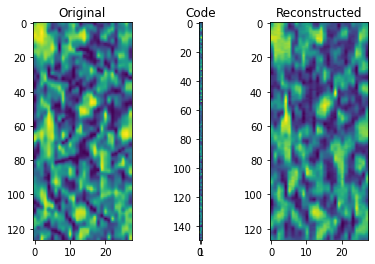

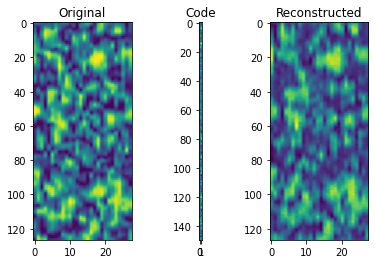

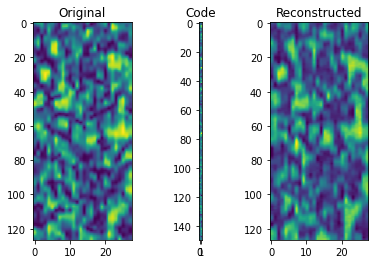

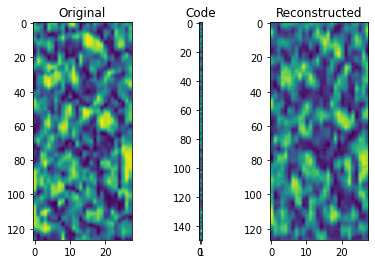

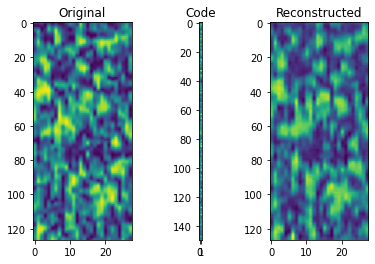

In [47]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [38]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {'loss':[],'val_loss':[]}

    def on_batch_end(self, batch, logs={}):
        self.history['loss'].append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.history['val_loss'].append(logs.get('val_loss'))

In [39]:
history = LossHistory()

In [40]:
def show_image(x):
    plt.imshow(np.clip(x, 0, 1), aspect='auto')

def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(np.squeeze(img))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(np.squeeze(reco))
    plt.show()

In [68]:
from sklearn.manifold import TSNE

codes = np.zeros([5000, 300])

for i in range(5000):
  img = data[i]
  codes[i] = encoder.predict(img[None])[0]


Y = TSNE(n_components=3, perplexity=100).fit_transform(codes)

In [64]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5).fit(codes)

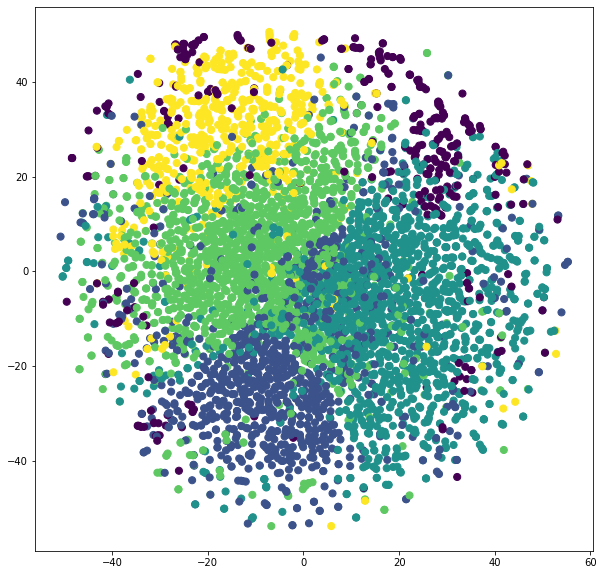

In [67]:
plt.figure(figsize=(10, 10))
plt.scatter(Y[:,0], Y[:,1], s=50, c=kmeans.labels_)

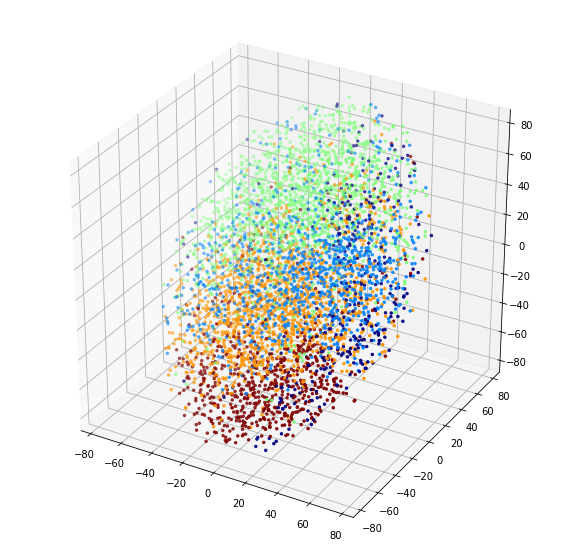

In [76]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(Y[:,0], Y[:,1], Y[:,1], s = 6, c=kmeans.labels_, cmap='jet')

In [22]:
img.shape

(127, 28, 1)